In [10]:
%config Completer.use_jedi = False
import pickle
import numpy as np
import pandas as pd
import tensorflow.keras
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, UpSampling1D, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error

# format figures
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['legend.title_fontsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams['figure.figsize'] = [8, 6]

### Load data

In [2]:
with open("../data/quadrotor_data.pickle", "rb") as handle:
    x = pickle.load(handle)
    y = pickle.load(handle)

### Split train test data

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(140, 240, 9) (60, 240, 9)
(140,) (60,)


### Visualize data

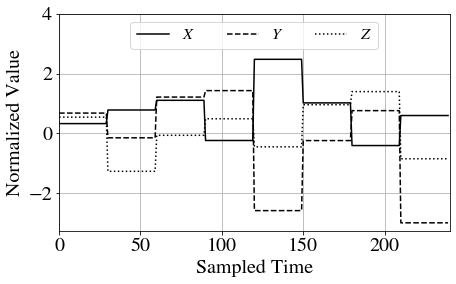

In [4]:
plt.figure(figsize=(7,4))
plt.plot(x_train[6, :, 0], label="$X$", c='k', linestyle='-')
plt.plot(x_train[6, :, 2], label="$Y$", c='k', linestyle='--')
plt.plot(x_train[6, :, 4], label="$Z$", c='k', linestyle=':')
plt.ylim([None, 4])
plt.xlim([0, 240])
plt.xlabel('Sampled Time')
plt.ylabel("Normalized Value")
plt.legend(ncol=3, loc='upper center', fontsize=16)
plt.grid()
plt.show()

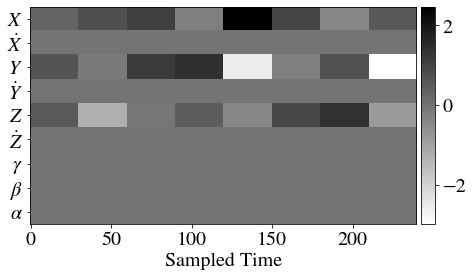

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(x_train[6, ...].T, cmap="gray_r", aspect=15, interpolation='none')
ax.set_xlabel('Sampled Time')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8], [r"$X$", r"$\dot{X}$", r"$Y$", 
                                         r"$\dot{Y}$", r"$Z$", r"$\dot{Z}$",
                                         r"$\gamma$", r"$\beta$", r"$\alpha$"])
plt.colorbar(im, fraction=1/15, pad=0.01, aspect=15)
plt.show()

### Build 1D CNN model

In [9]:
np.random.seed(0)
tf.random.set_random_seed(0)
input = Input(shape=(240, 9))
x = Conv1D(64, (3), activation='relu')(input)
x = MaxPooling1D((2))(x)
x = Conv1D(64, (3), activation='relu')(x)
x = MaxPooling1D((2))(x)
x = Conv1D(64, (3), activation='relu')(x)
x = MaxPooling1D((2))(x)
x = Conv1D(64, (3), activation='relu')(x)
x = MaxPooling1D((2))(x)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
x = Dense(1, activation='linear')(x)

cnn = Model(input, x)
cnn.compile(optimizer='adam', loss='mean_squared_error')

### Training 1D CNN

In [7]:
checkpoint = ModelCheckpoint('../weight/quadrotor.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
# cnn.fit(x_train, y_train, validation_split=0.25, epochs=1000, callbacks=[checkpoint], verbose=0, batch_size=128) # You may uncomment and train your own network
cnn.load_weights('../weight/quadrotor.h5')
y_pred = cnn.predict(x_test)

### Plot parity plot

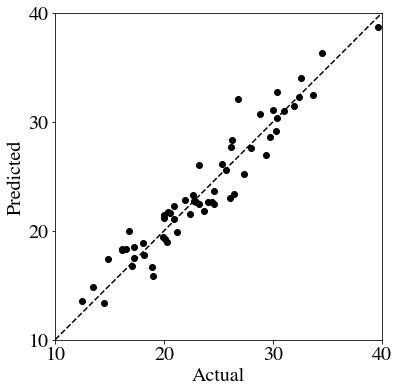

RMSE: 1.7100


In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, c='k')
plt.plot(np.arange(10, 41, 0.5), np.arange(10, 41, 0.5), 'k--')
plt.axis("square")
plt.xlim([10, 40])
plt.ylim([10, 40])
plt.locator_params(axis='x', nbins=5)
plt.locator_params(axis='y', nbins=5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5 :0.4f}")